In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from config.settings import DB_PATH
import data_processing.load_sqlite as load_sql

## Compare MovieLens Ratings with TMDB vote averages

In [2]:
query = """
SELECT 
    m.movie_id,
    m.vote_count,
    m.vote_average,
    COUNT(umr.rating) AS user_rating_count,
    AVG(umr.rating) AS user_rating_average
FROM movie m
JOIN movie_link ml ON m.movie_id = ml.tmdb_id
JOIN user_movie_rating umr ON ml.movielens_id = umr.movielens_id
GROUP BY m.movie_id;
"""

with sqlite3.connect(DB_PATH) as conn:
    df = pd.read_sql_query(query, conn)

df.head()

,movie_id,vote_count,vote_average,user_rating_count,user_rating_average
0,2,341,7.113,322,3.689441
1,3,404,7.300,145,3.675862
2,5,2674,5.858,6191,3.403489
3,6,345,6.500,1293,2.933101
4,11,20915,8.200,85010,4.099824


### Filter out low counts

In [3]:
min_count = 30
df_filtered = df[(df['user_rating_count'] >= min_count) & (df['vote_count'] >= min_count)]
df_filtered.head()

,movie_id,vote_count,vote_average,user_rating_count,user_rating_average
0,2,341,7.113,322,3.689441
1,3,404,7.300,145,3.675862
2,5,2674,5.858,6191,3.403489
3,6,345,6.500,1293,2.933101
4,11,20915,8.200,85010,4.099824


In [4]:
df_filtered.corr(numeric_only=True)["vote_average"].sort_values(ascending=False)

vote_average           1.000000
user_rating_average    0.831363
vote_count             0.245116
user_rating_count      0.240255
movie_id               0.063159
Name: vote_average, dtype: float64

## Checking distributions of ratings and votes

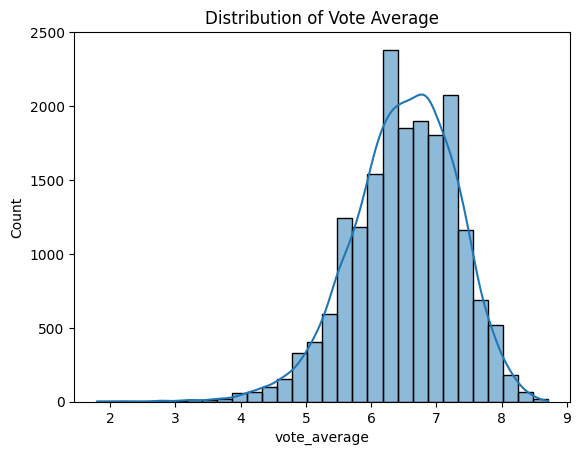

In [5]:
sns.histplot(df_filtered["vote_average"], bins=30, kde=True)
plt.title("Distribution of Vote Average")
plt.show()

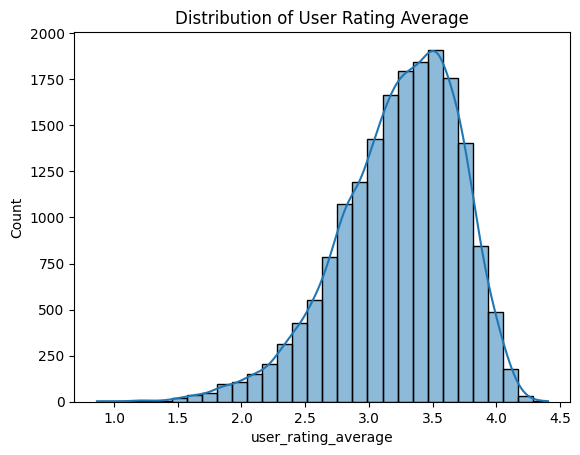

In [6]:
sns.histplot(df_filtered["user_rating_average"], bins=30, kde=True)
plt.title("Distribution of User Rating Average")
plt.show()

## Loading non-categorical features

In [2]:
with sqlite3.connect(DB_PATH) as conn:
    cursor = conn.cursor()
    query = """SELECT * FROM movie_rating_features;"""
    df_all = pd.read_sql_query(query, conn)

df_all.head()

,movie_id,vote_average,title,release_date,runtime,top_5_cast_ids,num_cast_members,director_ids,writer_ids,company_ids,genre_ids
0,2,7.113,Ariel,1988-10-21,73,None,0,None,None,2303,"18,35,80,10749"
1,3,7.300,Shadows in Paradise,1986-10-17,74,None,0,None,None,2303,"18,35,10749"
2,5,5.858,Four Rooms,1995-12-09,98,"3129,3130,3131,3124,2555",28,"138,2294,3110,3111","138,2294,3110,3111","14,59","35,80"
3,6,6.500,Judgment Night,1993-10-15,109,"2880,9777,5724,10822,12799",31,2042,"52035,52035,1088307","33,182,1644","28,53,80"
4,11,8.200,Star Wars,1977-05-25,121,"2,3,4,5,12248",104,1,1,"1,25","12,28,878"


In [3]:
df_all['release_date'] = pd.to_datetime(df_all['release_date'])
df_all['release_date_numeric'] = df_all['release_date'].astype(int) / 10**9  # Unix timestamp in seconds
df_num = df_all.select_dtypes(include=['number'])

df_num.head()

,movie_id,vote_average,runtime,num_cast_members,release_date_numeric
0,2,7.113,73,0,593395200.0
1,3,7.300,74,0,529891200.0
2,5,5.858,98,28,818467200.0
3,6,6.500,109,31,750643200.0
4,11,8.200,121,104,233366400.0


## Loading genres

In [4]:
df_genre = load_sql.fetch_one_hot_genres(vote_count_min=30)
df_genre.head()

,movie_id,Adventure,Fantasy,Animation,Drama,Horror,Action,Comedy,History,Western,Thriller,Crime,Documentary,Science Fiction,Mystery,Music,Romance,Family,War,TV Movie
0,2,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
1,3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,5,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0
4,11,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [5]:
df = pd.merge(df_num, df_genre, on='movie_id')
df.head()

,movie_id,vote_average,runtime,num_cast_members,release_date_numeric,Adventure,Fantasy,Animation,Drama,Horror,...,Thriller,Crime,Documentary,Science Fiction,Mystery,Music,Romance,Family,War,TV Movie
0,2,7.113,73,0,593395200.0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
1,3,7.300,74,0,529891200.0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,5,5.858,98,28,818467200.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,6,6.500,109,31,750643200.0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
4,11,8.200,121,104,233366400.0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Scores with the addition of MovieLens ratings data 

In [6]:
# Setting all the parameters
lambda_director   = 0.000408
lambda_writers    = 0.000377
lambda_cast_time  = 0.000592
lambda_cast_order = 0.122

df_scores = load_sql.fetch_scores(lambda_director, lambda_writers, lambda_cast_time, lambda_cast_order)
df_scores.head()

,movie_id,director_score,writer_score,cast_score,production_company_score
0,2,6.274975,6.274975,6.274975,6.871155
1,3,6.274975,6.274975,6.274975,6.826759
2,5,7.310514,7.302301,6.689616,6.558449
3,6,5.488217,6.046315,6.359513,6.294667
4,11,7.172478,7.043476,6.337137,6.589013


In [7]:
df = pd.merge(df, df_scores, on='movie_id')
df.head()

,movie_id,vote_average,runtime,num_cast_members,release_date_numeric,Adventure,Fantasy,Animation,Drama,Horror,...,Mystery,Music,Romance,Family,War,TV Movie,director_score,writer_score,cast_score,production_company_score
0,2,7.113,73,0,593395200.0,0,0,0,1,0,...,0,0,1,0,0,0,6.274975,6.274975,6.274975,6.871155
1,3,7.300,74,0,529891200.0,0,0,0,1,0,...,0,0,1,0,0,0,6.274975,6.274975,6.274975,6.826759
2,5,5.858,98,28,818467200.0,0,0,0,0,0,...,0,0,0,0,0,0,7.310514,7.302301,6.689616,6.558449
3,6,6.500,109,31,750643200.0,0,0,0,0,0,...,0,0,0,0,0,0,5.488217,6.046315,6.359513,6.294667
4,11,8.200,121,104,233366400.0,1,0,0,0,0,...,0,0,0,0,0,0,7.172478,7.043476,6.337137,6.589013


## Models

In [8]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
# Define features (everything except 'vote_average')
X_train = train_df.drop(columns=['vote_average', 'movie_id'])
X_test = test_df.drop(columns=['vote_average', 'movie_id'])

# Define target
y_train = train_df['vote_average']
y_test = test_df['vote_average']

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbrt.fit(X_train, y_train)

print(gbrt.score(X_train, y_train))
print(gbrt.score(X_test, y_test))

0.4153305243109279
0.40392473768028425


In [11]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print("Training score:", rf.score(X_train, y_train))
print("Testing score:", rf.score(X_test, y_test))

Training score: 0.9164035431372642
Testing score: 0.40596282093704006


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Create a RandomForestRegressor model with regularization
rf_model = RandomForestRegressor(
    n_estimators=100,               # Reduce number of estimators
    max_depth=20,                   # Limit tree depth
    min_samples_split=10,           # Require more samples to split
    min_samples_leaf=5,             # Require more samples for leaf nodes
    max_features='sqrt',            # Limit features for each split
    random_state=42                 # Set a seed for reproducibility
)

# Perform 5-fold cross-validation
cross_val_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

print(f"Cross-validation scores: {cross_val_scores}")
print(f"Average cross-validation score: {cross_val_scores.mean()}")

# Fit the final model
rf_model.fit(X_train, y_train)

print(f"Train score: {rf_model.score(X_train, y_train)}")
print(f"Test score: {rf_model.score(X_test, y_test)}")


Cross-validation scores: [0.42172741 0.41327898 0.4485746  0.42334085 0.42283301]
Average cross-validation score: 0.4259509698378885
Train score: 0.5736770070253971
Test score: 0.4348231443113866


## Conclusions

The addition of the MovieLens ratings data does not have any real effect on the accuracy of the models. In particular, it does not seem worth the score-computation time to include the MovieLens rating data here. 